<a href="https://colab.research.google.com/github/renewable-energy-experiments/carbonfoorprint/blob/master/US_CarbonEmission_EIA__vs_IPCC_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> US electricity generation by energy source ( price , co2 emission by grids)<center><h1> 
  High granularity Power generation CA ISO ( California) 

# Table of Contents
* [1. DataSet Description](#section-one)
* [2. Plot Generation graph](#section-two)
* [3. Plot Carbon Emission graph ( only fossil fuels)  ](#section-three)
* [4. Plot Carbon Emission graph ( Renwables Lifecycle emission included) ](#section-four)

In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates 
xformatter = mdates.DateFormatter('%H:%M') # for time axis plots

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

import sklearn
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

<a id="section-one"></a>
# 1. DataSet Description

1. Dataset is weekly reports from EIA for WAshington 2018.


2. Non renewable ignoring Carbon emission from EIA 
https://www.eia.gov/environment/emissions/state/ 
Energy-Related CO2 Emission Data Tables , Table 3.2018 State energy-related carbon dioxide emissions by fuel

3. Carbon ifecycle emission including non renewables from IPCC
https://www.ipcc.ch/site/assets/uploads/2018/02/ipcc_wg3_ar5_annex-iii.pdf#page=7
Table A.III.2 | Emissions of selected electricity supply technologies (gCO2eq/kWh)i , page 1335 


In [6]:
# Import generation  data 
df = pd.read_csv("/content/NW_energy_by_source_july_1st_week_2018.csv.csv")
df.head()

,Region Code,Timestamp (Hour Ending),Wind Generation (MWh),Solar Generation (MWh),Hydro Generation (MWh),Other Generation (MWh),Petroleum Generation (MWh),Natural gas Generation (MWh),Coal Generation (MWh),Nuclear Generation (MWh)
0,NW,7/1/2018 1 a.m. MDT,1391,-1,864,47,59,1925,5839,NaN
1,NW,7/1/2018 2 a.m. MDT,4651,-1,16111,734,60,6222,8689,1146.0
2,NW,7/1/2018 3 a.m. MDT,4139,0,15155,748,59,6055,8655,1148.0
3,NW,7/1/2018 4 a.m. MDT,3562,0,15037,754,59,5798,8508,1150.0
4,NW,7/1/2018 5 a.m. MDT,3345,0,15064,774,58,5749,8387,1152.0


In [7]:
# Import carbon emission IPCC 2014 data along with carbon foorptint for renewables
df_carbon = pd.read_csv("/content/US Utility grids - LCOE, Co2 Emissions - Carbon3.csv")
df_carbon

,Fuel Type,Lifecycle emissions (gCO2eq/kWh),Lifecycle emissions (kgCO2eq/MWh)
0,Nuclear,12,12
1,Hydro,24,24
2,Wind,12,12
3,Solar,48,48
4,NaturalGas,490,490
5,Oil,490,490
6,Coal,820,820
7,Other,24,24


In [84]:
# Import carbon emission EIA 2018 data without carbon foorptint for renewables
# df_carbon2 = pd.read_csv("/content/table3.csv")
# df_carbon2.head()

df_carbon2 = pd.read_excel('/content/table3.xlsx', index_col=0, header =3)
# df_carbon2= df_carbon2[2:]
df_carbon2.drop(df_carbon2.iloc[:,4:], axis = 1, inplace = True)

df_carbon2 = df_carbon2.rename(columns={"Petroleum": "Oil",
                                        "Natural Gas ": "NaturalGas"
                       })

df_carbon2.head()

,Coal,Oil,NaturalGas,Total
State,,,,
Alabama,35.92,36.67,40.90,113.49
Alaska,1.64,15.19,18.37,35.20
Arizona,31.66,37.48,21.25,90.39
Arkansas,29.05,22.95,19.47,71.47
California,3.15,242.69,117.12,362.96


In [14]:
Region="NorthWestern (Washington)"

In [15]:
column_list_gen = ("Wind","Solar","Hydro","Nuclear", "Other", 
                "NaturalGas","Oil","Coal","total_generation")

In [19]:
df = df.rename(columns={"Wind Generation (MWh)": "Wind",
                        "Solar Generation (MWh)" : "Solar",
                        "Hydro Generation (MWh)": "Hydro",
                        "Nuclear Generation (MWh)": "Nuclear",
                        "Other Generation (MWh)": "Other",
                        "Natural gas Generation (MWh)": "NaturalGas",
                        "Petroleum Generation (MWh)" : "Oil",
                        "Coal Generation (MWh)": "Coal"
                       })
df.head()

,Region Code,Timestamp (Hour Ending),Wind,Solar,Hydro,Other,Oil,NaturalGas,Coal,Nuclear
0,NW,7/1/2018 1 a.m. MDT,1391,-1,864,47,59,1925,5839,NaN
1,NW,7/1/2018 2 a.m. MDT,4651,-1,16111,734,60,6222,8689,1146.0
2,NW,7/1/2018 3 a.m. MDT,4139,0,15155,748,59,6055,8655,1148.0
3,NW,7/1/2018 4 a.m. MDT,3562,0,15037,754,59,5798,8508,1150.0
4,NW,7/1/2018 5 a.m. MDT,3345,0,15064,774,58,5749,8387,1152.0


In [28]:
df['Timestamp (Hour Ending)'] = pd.to_datetime(df['Timestamp (Hour Ending)'],format = '%d-%m-%Y %H:%M', errors='ignore')
df["DATE"] = pd.to_datetime(df["Timestamp (Hour Ending)"]).dt.date # add new column with date
df["TIME"] = pd.to_datetime(df["Timestamp (Hour Ending)"]).dt.time # add new column with time
# add hours and minutes for ml models
df['HOURS'] = pd.to_datetime(df['TIME'],format='%H:%M:%S').dt.hour

df.head()

,Region Code,Timestamp (Hour Ending),Wind,Solar,Hydro,Other,Oil,NaturalGas,Coal,Nuclear,Timestamp,DATE,TIME,HOURS
0,NW,7/1/2018 1 a.m. MDT,1391,-1,864,47,59,1925,5839,NaN,0,2018-07-01,01:00:00,1
1,NW,7/1/2018 2 a.m. MDT,4651,-1,16111,734,60,6222,8689,1146.0,1,2018-07-01,02:00:00,2
2,NW,7/1/2018 3 a.m. MDT,4139,0,15155,748,59,6055,8655,1148.0,2,2018-07-01,03:00:00,3
3,NW,7/1/2018 4 a.m. MDT,3562,0,15037,754,59,5798,8508,1150.0,3,2018-07-01,04:00:00,4
4,NW,7/1/2018 5 a.m. MDT,3345,0,15064,774,58,5749,8387,1152.0,4,2018-07-01,05:00:00,5


In [32]:
df["total_generation"] = df["Wind"] + df["Solar"] + df["Hydro"] + df["Other"]+ df["Oil"] + df["NaturalGas"] + df["Coal"] + df["Nuclear"]
df[["TIME","total_generation"]]

,TIME,total_generation
0,01:00:00,NaN
1,02:00:00,37612.0
2,03:00:00,35959.0
3,04:00:00,34868.0
4,05:00:00,34529.0
...,...,...
163,20:00:00,51436.0
164,21:00:00,50537.0
165,22:00:00,48267.0
166,23:00:00,46763.0


<a id="section-two"></a>
# 2. Plot Generation graph

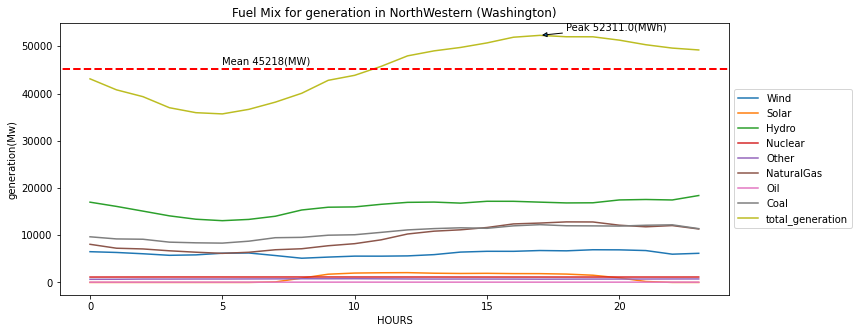

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

sub_df= df[df['DATE']==datetime.date(2018, 7, 2)]
sub_df.plot.line(x='HOURS', y = np.array(column_list_gen), ax = ax, title = "Fuel Mix for generation in "+ Region , legend=False)

ax.set_ylabel("generation(Mw)")

mean_gen = round(sub_df["total_generation"].mean())
max_gen = sub_df["total_generation"].max()
maxh = sub_df.loc[sub_df["total_generation"]== max_gen]
maxh = maxh["HOURS"]
ax.axhline(y=mean_gen, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)

ax.text(5,mean_gen+1000, "Mean " + str(mean_gen) + "(MW)" )

#     ax.get_legend().remove()

ax.annotate('Peak '+ str(max_gen)+ "(MWh)", xy=(maxh,max_gen), xytext=(maxh+1, max_gen+1000),
          arrowprops=dict(arrowstyle='-|>') ,ha='left', rotation=0)

# ax.set_ylim(bottom = 0,top=39000)
    
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

<a id="section-three"></a>
# 3. Plot Carbon graphs ( only fossil fuel sources )

In [147]:
df_carbon2 = df_carbon2[df_carbon2.index=="Washington"]
df_carbon2

,Coal,Oil,NaturalGas,Total,total_emission
State,,,,,
Washington,5.84,55.24,17.76,78.85,78.84


Text(0, 0.5, 'Carbon Emission (million metric tons of carbon dioxide)')

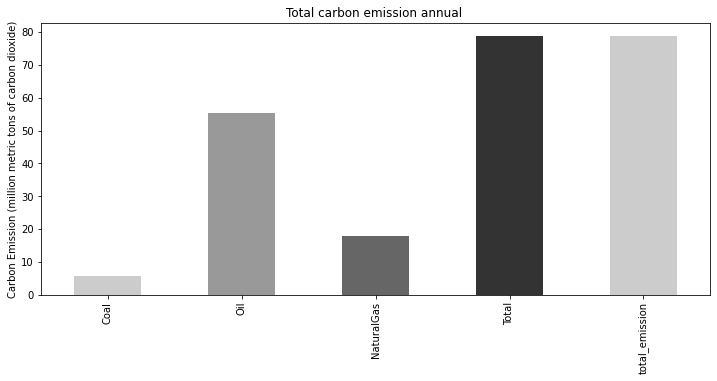

In [148]:
# for col in df[np.array(column_list_gen)].columns:
#     # print(df[col])
#     print(col)
#     for carboncol in df_carbon2.columns:
#         # print(carbon)
#         if col in carboncol:
#             print("Match between two tables for "+col+ " and "+ carboncol )
#             print(df_carbon2[carboncol][0])
#             df['carbon2_'+col] = df[col] * df_carbon2[carboncol][0]
            
# df.head()

import seaborn as sns
cmap = sns.color_palette("gray_r", n_colors=4)

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

df_carbon2.sum().plot.bar(
            ax = ax, 
            color=cmap, 
            title="Total carbon emission annual ")
ax.set_ylabel("Carbon Emission (million metric tons of carbon dioxide)")  

In [144]:
# df_carbon2['total_emission']= df_carbon2["NaturalGas"] + df_carbon2["Oil"] + df_carbon2["Coal"]
# df_carbon2_avgday = df_carbon2_avgday.drop(['total_emission'], axis = 1)

## million metric tons annually to avg day metric tons 
df_carbon2_avgday = df_carbon2.iloc[: ,: ] * 1000000 /365

##  metric tons to kg for daily 
df_carbon2_avgday = df_carbon2.iloc[: ,: ] * 1000

df_carbon2_avgday.head()

,Coal,Oil,NaturalGas,Total
State,,,,
Washington,5840.0,55240.0,17760.0,78850.0


In [124]:
# column_list2 = (
#                 "carbon2_NaturalGas","carbon2_Oil","carbon2_Coal","carbon2_total_emission")

Text(0, 0.5, 'Carbon Emission (metric tons of carbon dioxide)')

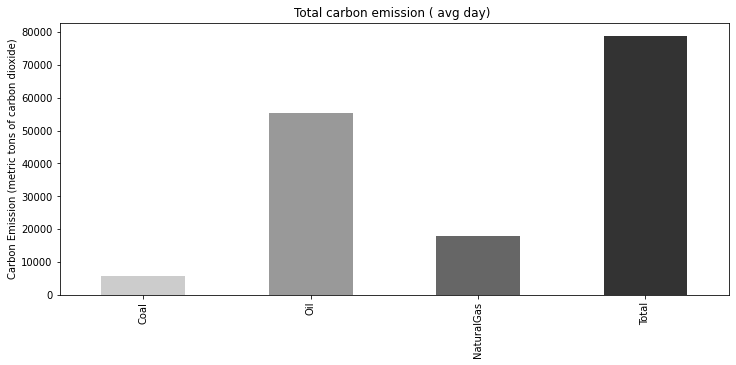

In [145]:
import seaborn as sns
cmap = sns.color_palette("gray_r", n_colors=4)

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

df_carbon2_avgday.sum().plot.bar(
            ax = ax, 
            color=cmap, 
            title="Total carbon emission ( avg day) ")
ax.set_ylabel("Carbon Emission (kg carbon dioxide)")  

# fig, ax = plt.subplots()
# fig.set_size_inches(12, 5)

# date = datetime.date(2018, 7, 2)
# sub_df_carbon2= df[df['DATE']== date]

# sub_df_carbon2.plot(x='HOURS', y = np.array(column_list2), ax = ax, 
#              color=cmap, 
#               # kind='area', stacked=False,
#               title = "Carbon Emission by Fuel for generation in "+ Region + " on "+ str(date),legend=False)
# ax.set_ylabel("Carbon Emission (kgCO2eq/MWh)")   
# # ax.set_ylim(bottom = 0,top=50000)
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

<a id="section-four"></a>
# 4. Plot Carbon graphs ( with Lifecycle Emission of Carbon rich + Renewable fuel sources )

In [ ]:
column_list = ("carbon_Wind","carbon_Solar","carbon_Hydro","carbon_Nuclear", "carbon_Other", 
                "carbon_NaturalGas","carbon_Oil","carbon_Coal","carbon_total_emission")

Text(0, 0.5, 'Carbon Emission (kgCO2eq/MWh)')

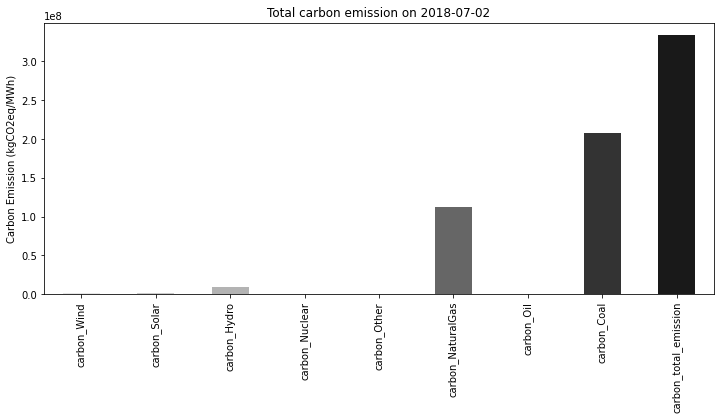

In [131]:
import seaborn as sns
cmap = sns.color_palette("gray_r", n_colors=9)

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
date = datetime.date(2018, 7, 2)
df= df[df['DATE']== date]
df[np.array(column_list)].sum().plot.bar(
              ax = ax, 
             color=cmap, 
              # kind='area', stacked=False,
            title="Total carbon emission on "+ str(date))
ax.set_ylabel("Carbon Emission (kgCO2eq/MWh)")   

In [41]:
for col in df.columns:
    # print(df[col])
    for j,carbon in df_carbon.iterrows():
        if col in carbon[0]:
            print("Match between two tables for "+col+ " and "+ carbon[0] +" - "+ str(carbon[1]))
            df['carbon_'+col] = df[col] * carbon[1]
            
df.head()

Match between two tables for Wind and Wind - 12
Match between two tables for Solar and Solar - 48
Match between two tables for Hydro and Hydro - 24
Match between two tables for Other and Other - 24
Match between two tables for Oil and Oil - 490
Match between two tables for NaturalGas and NaturalGas - 490
Match between two tables for Coal and Coal - 820
Match between two tables for Nuclear and Nuclear - 12


,Region Code,Timestamp (Hour Ending),Wind,Solar,Hydro,Other,Oil,NaturalGas,Coal,Nuclear,Timestamp,DATE,TIME,HOURS,total_generation,carbon_Wind,carbon_Solar,carbon_Hydro,carbon_Other,carbon_Oil,carbon_NaturalGas,carbon_Coal,carbon_Nuclear
0,NW,7/1/2018 1 a.m. MDT,1391,-1,864,47,59,1925,5839,NaN,0,2018-07-01,01:00:00,1,NaN,16692,-48,20736,1128,28910,943250,4787980,NaN
1,NW,7/1/2018 2 a.m. MDT,4651,-1,16111,734,60,6222,8689,1146.0,1,2018-07-01,02:00:00,2,37612.0,55812,-48,386664,17616,29400,3048780,7124980,13752.0
2,NW,7/1/2018 3 a.m. MDT,4139,0,15155,748,59,6055,8655,1148.0,2,2018-07-01,03:00:00,3,35959.0,49668,0,363720,17952,28910,2966950,7097100,13776.0
3,NW,7/1/2018 4 a.m. MDT,3562,0,15037,754,59,5798,8508,1150.0,3,2018-07-01,04:00:00,4,34868.0,42744,0,360888,18096,28910,2841020,6976560,13800.0
4,NW,7/1/2018 5 a.m. MDT,3345,0,15064,774,58,5749,8387,1152.0,4,2018-07-01,05:00:00,5,34529.0,40140,0,361536,18576,28420,2817010,6877340,13824.0


In [48]:
df['carbon_total_emission']= df["carbon_Wind"] + df["carbon_Solar"]+ df["carbon_Hydro"] + df["carbon_Other"]+ df["carbon_Oil"] + df["carbon_NaturalGas"] + df["carbon_Coal"]+ df["carbon_Nuclear"]
df.head()

,Region Code,Timestamp (Hour Ending),Wind,Solar,Hydro,Other,Oil,NaturalGas,Coal,Nuclear,Timestamp,DATE,TIME,HOURS,total_generation,carbon_Wind,carbon_Solar,carbon_Hydro,carbon_Other,carbon_Oil,carbon_NaturalGas,carbon_Coal,carbon_Nuclear,carbon_total_emission
0,NW,7/1/2018 1 a.m. MDT,1391,-1,864,47,59,1925,5839,NaN,0,2018-07-01,01:00:00,1,NaN,16692,-48,20736,1128,28910,943250,4787980,NaN,NaN
1,NW,7/1/2018 2 a.m. MDT,4651,-1,16111,734,60,6222,8689,1146.0,1,2018-07-01,02:00:00,2,37612.0,55812,-48,386664,17616,29400,3048780,7124980,13752.0,10676956.0
2,NW,7/1/2018 3 a.m. MDT,4139,0,15155,748,59,6055,8655,1148.0,2,2018-07-01,03:00:00,3,35959.0,49668,0,363720,17952,28910,2966950,7097100,13776.0,10538076.0
3,NW,7/1/2018 4 a.m. MDT,3562,0,15037,754,59,5798,8508,1150.0,3,2018-07-01,04:00:00,4,34868.0,42744,0,360888,18096,28910,2841020,6976560,13800.0,10282018.0
4,NW,7/1/2018 5 a.m. MDT,3345,0,15064,774,58,5749,8387,1152.0,4,2018-07-01,05:00:00,5,34529.0,40140,0,361536,18576,28420,2817010,6877340,13824.0,10156846.0


In [50]:
dates = df['DATE'].unique()
dates

array([datetime.date(2018, 7, 1), datetime.date(2018, 7, 2),
       datetime.date(2018, 7, 3), datetime.date(2018, 7, 4),
       datetime.date(2018, 7, 5), datetime.date(2018, 7, 6),
       datetime.date(2018, 7, 7), datetime.date(2018, 7, 8)], dtype=object)

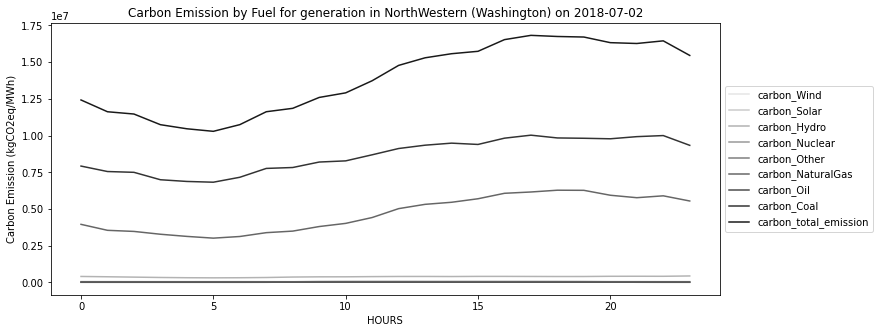

In [56]:
import seaborn as sns
cmap = sns.color_palette("gray_r", n_colors=9)

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
date = datetime.date(2018, 7, 2)
sub_df_carbon= df[df['DATE']== date]
sub_df_carbon.plot(x='HOURS', y = np.array(column_list), ax = ax, 
             color=cmap, 
              # kind='area', stacked=False,
              title = "Carbon Emission by Fuel for generation in "+ Region + " on "+ str(date),legend=False)
ax.set_ylabel("Carbon Emission (kgCO2eq/MWh)")   
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [53]:
# import seaborn as sns
# cmap = sns.color_palette("Blues_r", n_colors=4)

# fig, ax = plt.subplots()
# fig.set_size_inches(12, 5)
# df.plot(x='MINUTES_PASS', y = np.array(column_list)[0:4], ax = ax, 
#              color=cmap, 
#               # kind='area', stacked=False,
#               title = "Carbon Emission by Fuel for generation in "+ Region + " on "+ pp,legend=False)
# ax.set_ylabel("Carbon Emission (kgCO2eq/MWh)")   
# # ax.set_ylim(bottom = 0,top=50000)
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [54]:
# ## Without total carbon emission 
# import seaborn as sns
# cmap = sns.color_palette("gray_r", n_colors=8)

# fig, ax = plt.subplots()
# fig.set_size_inches(12, 5)
# df.plot(x='MINUTES_PASS', y = np.array(column_list)[0:8], ax = ax, 
#              color=cmap, 
#               kind='area', stacked=True,
#               title = "Carbon Emission by Fuel for generation in "+ Region + " on "+ pp,legend=False)
# ax.set_ylabel("Carbon Emission (kgCO2eq/MWh)")
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [58]:
# ## With total carbon emission 
# import seaborn as sns
# cmap = sns.color_palette("gray_r", n_colors=9)

# fig, ax = plt.subplots()
# fig.set_size_inches(12, 5)
# df.plot(x='MINUTES_PASS', y = np.array(column_list), ax = ax, 
#              color=cmap, 
#           kind='area', stacked=True,
#               title = "Carbon Emission by Fuel for generation in "+ Region + " on "+ pp,legend=False)
# ax.set_ylabel("Carbon Emission (kgCO2eq/MWh)")

# # mean_gen = round(sub_df["total_generation"].mean())
# # max_gen = sub_df["total_generation"].max()
# # maxh = sub_df.loc[sub_df["total_generation"]== max_gen]
# # maxh = maxh["HOURS"]

# # Mark Mean Line 
# # ax.axhline(y=mean_gen, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
# # ax.text(5,mean_gen+1000, "Mean " + str(mean_gen) + "(MW)" )

# # ax.get_legend().remove()

# # Mark Peak consumption 
# # ax.annotate('Peak '+ str(max_gen)+ "(MWh)", xy=(maxh,max_gen), xytext=(maxh+1, max_gen+1000),
# #              arrowprops=dict(arrowstyle='-|>') ,ha='left', rotation=0)
    
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# # plot.show(block=True);

2020-09-07


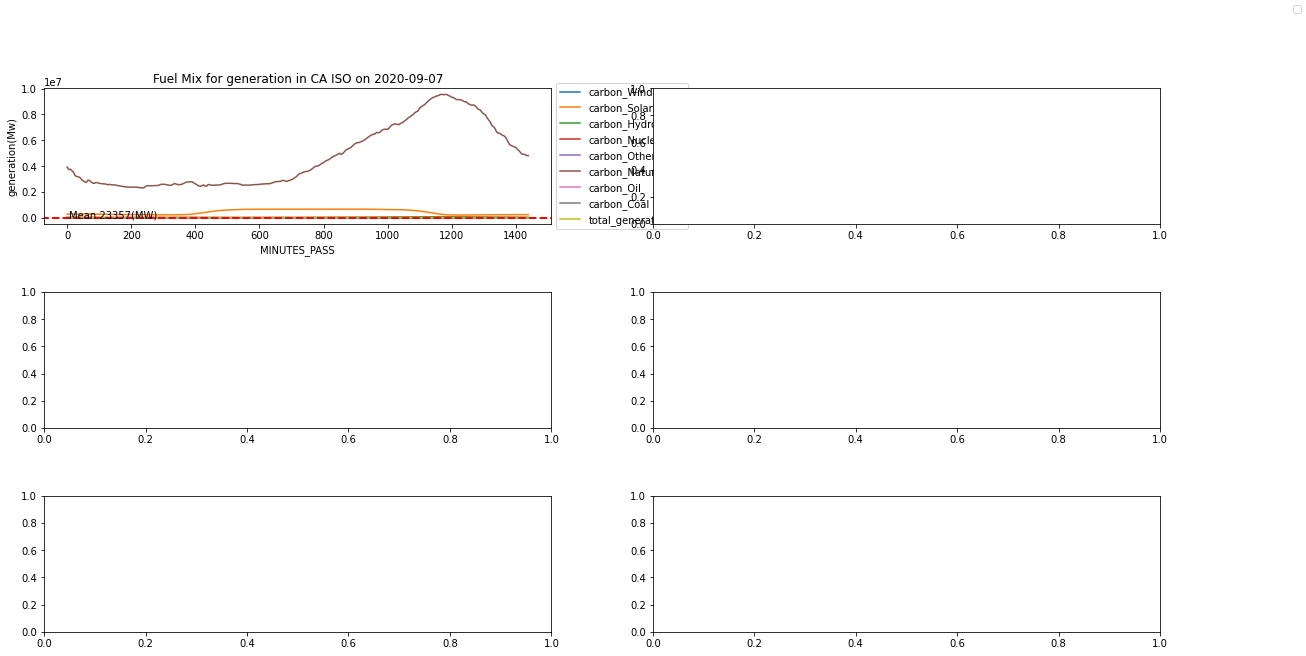

In [ ]:
# fig, axs = plt.subplots(nrows=3, ncols=2)
# fig.set_size_inches(20, 10)
# fig.subplots_adjust(wspace=0.2)
# fig.subplots_adjust(hspace=0.5)

# fig.legend(column_list)
  
# for pp,ax in zip(dates,axs.flatten()):
#     print(pp)
#     sub_df = df[df['DATE']==pp]
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[0], ax = ax, title = "Fuel Mix for generation in "+ Region + " on "+ pp,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[1], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[2], ax = ax,legend=False)    
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[3], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[4], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[5], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[6], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[7], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y =['total_generation'], ax = ax,legend=False)
    
#     ax.set_ylabel("generation(Mw)")
    
#     mean_gen = round(sub_df["total_generation"].mean())
#     max_gen = sub_df["total_generation"].max()
#     maxh = sub_df.loc[sub_df["total_generation"]== max_gen]
#     maxh = maxh["MINUTES_PASS"]
#     ax.axhline(y=mean_gen, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
    
#     ax.text(5,mean_gen+1000, "Mean " + str(mean_gen) + "(MW)" )

# #     ax.get_legend().remove()
    
# #     ax.annotate('Peak '+ str(max_gen)+ "(MWh)", xy=(maxh,max_gen), xytext=(maxh+1, max_gen+1000),
# #              arrowprops=dict(arrowstyle='-|>') ,ha='left', rotation=0)
    
#     ax.set_ylim(bottom = 0,top=39000)
    
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))